<a href="https://colab.research.google.com/github/vasudev-sharma/Expand_AI-Assignment/blob/master/Expand_ai_problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount the drive on Google Colab

In [1]:
# install weights and biases, and torchkeras library
!pip install wandb
!pip install torchkeras

     |████████████████████████████████| 1.8MB 12.5MB/s 
     |████████████████████████████████| 133kB 38.2MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 163kB 36.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=eca78995d2fc6ceef8f2e8de555eb01576b07da56b76090a3afe9523c12740f4
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=6525d0ef8ff01c229eb5ab333c995e79ad467217220be25bfab7ed7274e6a807
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
     |████████████████████████████████| 808kB 11.6MB/s 
     |████████████████████████████████| 10.6MB 38.6MB/s 
     |█████████████████████████████

In [2]:
# import libraries
import os
import math
import random
import shutil
from tqdm import tqdm 
from pathlib import Path
import wandb

# import scientific libraries
import numpy as np

# import pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import time
import torch.nn.functional as F



In [3]:
# set seed to reproduce results
np.random.seed(42)

In [4]:
#@title
# initialize wandb for logging
!wandb login 202040aaac395bbf5a4a47d433a5335b74b7fb0e

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# The authorization code is
'4/1AY0e-g7pVJb2DWnP2SFA-Ase3aWHNpTaSh1g0G6E-maRTxV9UwCWWNJQ45s'

Mounted at /content/drive


In [6]:
# path of data
data_path = '/content/drive/MyDrive/data/diseases_copy4'
CLASSES = ["COVID", "NORMAL", "PNEUMONIA"]


In [332]:
!cp -r '/content/drive/MyDrive/data/diseases' '/content/drive/MyDrive/data/diseases_copy6'



# DATASET PREPARATION

In [7]:
data_path = Path(data_path) / 'train'
test_data_path = Path(data_path) / 'test'



In [ ]:
"""
# Change the data path to diseases_copy6
data_path = '/content/drive/MyDrive/data/diseases_copy6'

 
list_images = os.listdir(data_path)
len_data = len(list_images)
print(len_data)

"""

In [8]:
# Helper function to split the images into Train and Validation set

def split_images(list_images):

  for image in tqdm(list_images):

    # iterate through all the classes
    for class_index in range(len(CLASSES)):
      # COVID class
      if image.startswith(CLASSES[class_index]): 
        try:
          os.mkdir(os.path.join(data_path, CLASSES[class_index]))
        except Exception as e:
          pass

        shutil.move(os.path.join(data_path, image), os.path.join(data_path, CLASSES[class_index], image))

  print('Preprocessing of dataset is completed')

"\nfor classes in tqdm(os.listdir(str(train_data_path))):\n  list_image_per_class = os.listdir(str(train_data_path / classes))\n  image_keep = random.sample(list_image_per_class, 20) # 20 images for training as given in the problem statement\n  for image in list_image_per_class:\n    if image not in image_keep:\n      try: \n        os.unlink(str(train_data_path / classes / image))\n      except Exception as e:\n        print('Error encountered in removing the images')\n"

In [ ]:
# Split the images into 3 classes: "COVID", "NORMAL", "PNEUMONIA"
"""
split_images(list_images)
"""

In [9]:
# sanity check for problem 2
''' 
for classes in tqdm(os.listdir(str(train_data_path))):
 list_image_per_class = os.listdir(str(train_data_path / classes))
 assert len(list_image_per_class) == 20
'''

' \nfor classes in tqdm(os.listdir(str(train_data_path))):\n list_image_per_class = os.listdir(str(train_data_path / classes))\n assert len(list_image_per_class) == 20\n'

# DATASETS AND DATALOADERS

In [29]:
train_data_path = Path(data_path) / 'train'
test_data_path = Path(data_path) / 'test'

print(f'Train and test data paths are {train_data_path} and {test_data_path} respectively')

Train and test data paths are /content/drive/MyDrive/data/diseases_copy4/train and /content/drive/MyDrive/data/diseases_copy4/test respectively


In [30]:
# transforms
train_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
test_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [31]:
# datasets

ds_train = datasets.ImageFolder(str(train_data_path), transform = train_transform, target_transform = lambda t:torch.tensor(t).long())
ds_test = datasets.ImageFolder(str(test_data_path), transform = test_transform, target_transform = lambda t: torch.tensor(t).long())

In [32]:
# preparing data for problem 2
# Code has been adapted from GH repo - https://github.com/YU1ut/MixMatch-pytorch

# As per the problem: 
classes_len = 3
n_labeled_per_class = 20



In [273]:

def train_val_split(labels, n_labeled_per_class, classes_len):

    labels = np.array(labels)
    train_labeled_idxs = []
    train_unlabeled_idxs = []
    val_idxs = []

    for i in range(classes_len): 
        idxs = np.where(labels == i)[0]
        np.random.shuffle(idxs)
        train_labeled_idxs.extend(idxs[:n_labeled_per_class]) 
        train_unlabeled_idxs.extend(idxs[n_labeled_per_class:-10])
        val_idxs.extend(idxs[-10:])
    np.random.shuffle(train_labeled_idxs)
    np.random.shuffle(train_unlabeled_idxs)
    np.random.shuffle(val_idxs)

    return train_labeled_idxs, train_unlabeled_idxs, val_idxs

In [274]:
train_labeled_idxs, train_unlabeled_idxs, val_idxs = train_val_split(ds_train.targets, n_labeled_per_class, classes_len)

In [275]:
from PIL import Image

In [276]:
# data = list(map(Image.open, list(zip(*ds_train.samples))[0]))

In [277]:

def pil_loader(path: str):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


# TODO: specify the return type
def accimage_loader(path: str):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path: str):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)



In [278]:
class ChestXRay_labeled(datasets.ImageFolder):

    def __init__(self, root, indexs=None,
                 transform=None, target_transform=None,
                 loader=default_loader
                 , is_valid_file=None):
        super(ChestXRay_labeled, self).__init__(root,
                 transform=transform, target_transform=target_transform,
                 loader=loader,
                 is_valid_file=is_valid_file)
        
        if indexs is not None:
            self.samples = np.array(self.imgs)[indexs].tolist()
            # print(len(self.samples))
            self.targets = np.array(self.targets)[indexs]
            # print(type(self.targets[0]))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = super(ChestXRay_labeled, self).__getitem__(index)
        
        return img, target

In [339]:
# Train Dataset
train_labeled_dataset = ChestXRay_labeled(str(train_data_path), train_labeled_idxs, transform=train_transform, target_transform=lambda t:torch.tensor((float(t))).long())

In [340]:
# Validation and Test Datasets
val_dataset = ChestXRay_labeled(str(train_data_path), val_idxs, transform=test_transform, target_transform=lambda t:torch.tensor((float(t))).long())
test_dataset = ChestXRay_labeled(str(test_data_path), transform=test_transform, target_transform=lambda t:torch.tensor((float(t))).long())

In [341]:
train_labeled_dataset[0][1]

tensor(0)

In [342]:
assert len(train_labeled_idxs) == 60



In [343]:
print(len(train_labeled_idxs))
print(len(train_unlabeled_idxs))
print(len(val_idxs))

60
630
30


In [344]:
 class TransformTwice:

  def __init__(self, transform):
    self.transform = transform

  def __call__(self, inp):
    out1 = self.transform(inp)
    out2 = self.transform(inp)
    return out1, out2

In [345]:

class ChestXRay_unlabeled(datasets.ImageFolder):

    def __init__(self, root, indexs=None,
                 transform=None, target_transform=None,
                 loader=default_loader
                 , is_valid_file=None):
        super(ChestXRay_unlabeled, self).__init__(root,
                 transform=transform, target_transform=target_transform,
                 loader=loader,
                 is_valid_file=is_valid_file)
        self.targets = np.array([-1 for i in range(len(self.targets))])
        

In [346]:
train_unlabeled_dataset = ChestXRay_unlabeled(str(train_data_path), train_unlabeled_idxs, transform=TransformTwice(train_transform))


In [369]:
# set hyperparameters
batch_size = 16
lr = 5e-5
epochs = 30
log_freq = 10
ema_decay = 0.999
train_iteration = 1024 # No of iterations per epoch 
lambda_u = 75
T = 0.5

num_classes = len(CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')



In [370]:
# Train Dataloaders 
labeled_trainloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
unlabeled_trainloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [371]:
# Val loader 

# Testing the model on entire 900 images
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [372]:
# sanity check labeled train dataloader
for batch in labeled_trainloader:
  img, target =  batch
  
  print(img.shape)
  print(target.shape)
  print(target.dtype)
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.int64


In [373]:
# sanity check unlabeled train dataloader
for batch in unlabeled_trainloader:
  (img1, img2), _ =  batch
  
  print(img1.shape)
  print(img2.shape)
  print(_.shape)
  break 

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [374]:
# Class labels
print(train_unlabeled_dataset.class_to_idx)

{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


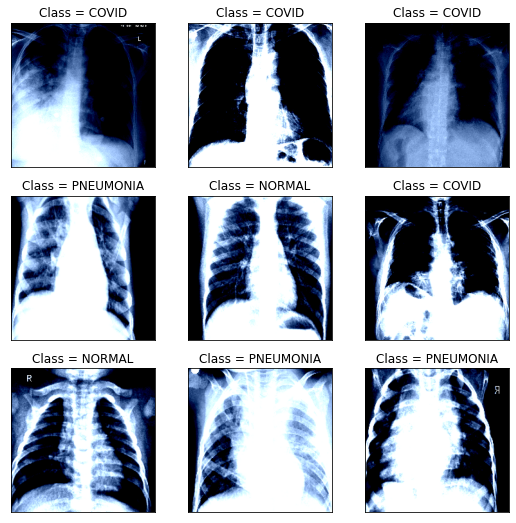

In [375]:
%matplotlib inline

# plot the images
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9))
# plot 9 images
for i in range(9):
  image, label = train_labeled_dataset[i]
  img = image.permute(1, 2, 0)
  ax = plt.subplot(3, 3, i + 1)
  ax.imshow(img.numpy())
  ax.set_title('Class = %s' % CLASSES[int(label.item())])
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

In [376]:
#@title
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual
    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate, activate_before_residual))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [377]:
def create_model(ema=False):
  # Move the model to CUDA, if available
  if torch.cuda.is_available():
    # model = WideResNet(num_classes=3)
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
    model.fc = nn.Linear(2048, num_classes)
    model.to(device)
  
  if ema == True:
    for param in model.parameters():
      param.detach_()
  return model


In [378]:
model = create_model()
ema_model = create_model(ema=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [379]:
next(ema_model.parameters()).is_cuda

True

In [380]:
#@title

def linear_rampup(current, rampup_length=epochs):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, lambda_u * linear_rampup(epoch)

class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        self.wd = 0.02 * lr

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param.dtype==torch.float32:
                ema_param.mul_(self.alpha)
                ema_param.add_(param * one_minus_alpha)
                # customized weight decay
                param.mul_(1 - self.wd)

def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [381]:
#@title

from typing import Tuple
# Macro F1 score PyTorch

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [382]:
# Define optimizer, loss, macro and micro F1 scores

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max = 5)
criterion = torch.nn.CrossEntropyLoss()

train_criterion = SemiLoss()
ema_optimizer= WeightEMA(model, ema_model, alpha=ema_decay)

macro_f1_score = F1Score(average='macro')
micro_f1_score = F1Score(average='micro')

In [383]:
#@title
'''def train_step(model, features, labels):
  # training
  model.train() 

  model.optimizer.zero_grad()

  logits = model(features)
  loss = model.loss_func(logits, labels)


  # compute the accuracy 
  probs = torch.softmax(logits, dim=1)
  predicted_labels = torch.argmax(logits, dim = 1)

  correct = predicted_labels == labels
  accuracy = correct.sum().float() / float(labels.size(0))

  # F1 metrics
  
  # macro F1 score
  macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

  # micro F1 score
  micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())


  # Backwardprop
  loss.backward()

  # Update the weights
  model.optimizer.step()
  model.scheduler.step()
  model.ema_optimizer.step()

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()'''


'def train_step(model, features, labels):\n  # training\n  model.train() \n\n  model.optimizer.zero_grad()\n\n  logits = model(features)\n  loss = model.loss_func(logits, labels)\n\n\n  # compute the accuracy \n  probs = torch.softmax(logits, dim=1)\n  predicted_labels = torch.argmax(logits, dim = 1)\n\n  correct = predicted_labels == labels\n  accuracy = correct.sum().float() / float(labels.size(0))\n\n  # F1 metrics\n  \n  # macro F1 score\n  macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())\n\n  # micro F1 score\n  micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())\n\n\n  # Backwardprop\n  loss.backward()\n\n  # Update the weights\n  model.optimizer.step()\n  model.scheduler.step()\n  model.ema_optimizer.step()\n\n  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()'

In [384]:
#@title
'''def valid_step(model, features, labels):
  # validation
  model.eval()

  with torch.no_grad():
    logits = model(features)
    loss = model.loss_func(logits, labels)
    
    # compute the accuracy 
    probs = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim = 1)

    correct = predicted_labels == labels
    accuracy = correct.sum().float() / float(labels.size(0))


    # F1 metrics
    
    # macro F1 score
    macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())

    # micro F1 score
    micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())

  

  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()
'''

'def valid_step(model, features, labels):\n  # validation\n  model.eval()\n\n  with torch.no_grad():\n    logits = model(features)\n    loss = model.loss_func(logits, labels)\n    \n    # compute the accuracy \n    probs = torch.softmax(logits, dim=1)\n    predicted_labels = torch.argmax(logits, dim = 1)\n\n    correct = predicted_labels == labels\n    accuracy = correct.sum().float() / float(labels.size(0))\n\n\n    # F1 metrics\n    \n    # macro F1 score\n    macro_f1_score = model.macro_f1_score(predicted_labels.flatten(), labels.flatten())\n\n    # micro F1 score\n    micro_f1_score = model.micro_f1_score(predicted_labels.flatten(), labels.flatten())\n\n  \n\n  return loss.item(), accuracy, macro_f1_score.item(), micro_f1_score.item()\n'

In [385]:
!pip install progress

In [386]:
from progress.bar import Bar 

class AverageMeter(object):
  def __init__(self):
    self.reset()
  
  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0
  
  def update(self, val, n=1):
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count


In [387]:
def train(labeled_trainloader, unlabeled_trainloader, model, epoch, train_iteration=1024, T=0.5, alpha=0.75):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_x = AverageMeter()
    losses_u = AverageMeter()
    ws = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=train_iteration)
    labeled_train_iter = iter(labeled_trainloader)
    unlabeled_train_iter = iter(unlabeled_trainloader)

    model.train()
    for batch_idx in range(train_iteration):
        try:
            inputs_x, targets_x = labeled_train_iter.next()
        except:
            labeled_train_iter = iter(labeled_trainloader)
            inputs_x, targets_x = labeled_train_iter.next()

        try:
            (inputs_u, inputs_u2), _ = unlabeled_train_iter.next()
        except:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            (inputs_u, inputs_u2), _ = unlabeled_train_iter.next()

        # measure data loading time
        data_time.update(time.time() - end)

        batch_size = inputs_x.size(0)

        # Transform label to one-hot
        targets_x = torch.zeros(batch_size, num_classes).scatter_(1, targets_x.view(-1,1).long(), 1)

        inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
        inputs_u = inputs_u.cuda()
        inputs_u2 = inputs_u2.cuda()

        with torch.no_grad():
            # compute guessed labels of unlabel samples
            outputs_u = model(inputs_u)
            outputs_u2 = model(inputs_u2)
            p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
            pt = p**(1/T)
            targets_u = pt / pt.sum(dim=1, keepdim=True)
            targets_u = targets_u.detach()

        # mixup
        all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

        l = np.random.beta(alpha, alpha)

        l = max(l, 1-l)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]


        mixed_input = l * input_a + (1 - l) * input_b
        mixed_target = l * target_a + (1 - l) * target_b



        # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
        mixed_input = list(torch.split(mixed_input, batch_size))
        mixed_input = interleave(mixed_input, batch_size)

        logits = [model(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(model(input))

        # put interleaved samples back
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        Lx, Lu, w = train_criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration)

        loss = Lx + w * Lu
        # print('The loss is ', loss)

        # record loss
        losses.update(loss.item(), inputs_x.size(0))
        losses_x.update(Lx.item(), inputs_x.size(0))
        losses_u.update(Lu.item(), inputs_x.size(0))
        ws.update(w, inputs_x.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | W: {w:.4f}'.format(
                    batch=batch_idx + 1,
                    size=train_iteration,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    w=ws.avg,
                    ))
  
    return (losses.avg, losses_x.avg, losses_u.avg,)


In [388]:
def valid(val_loader, model, epoch, mode):

  batch_time = AverageMeter()
  data_time = AverageMeter()
  losses = AverageMeter()
  macro_f1_scores = AverageMeter()
  micro_f1_scores = AverageMeter()
  accuracies = AverageMeter()

  model.eval()
  bar = Bar(f'{mode}', max=len(val_loader))
  end = time.time()
  print(f'\n************{mode}*************')
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):

      # measure data loading time
      data_time.update(time.time() - end)

      inputs, targets = inputs.cuda(), targets.cuda(non_blocking=True)

      # compute output
      outputs = model(inputs)

      # compute loss
      loss = criterion(outputs, targets)

      ## compute metrics
      # accuracy
      probs = torch.softmax(outputs, dim=1)
      predicted_labels = torch.argmax(probs, dim=1)

      correct = predicted_labels == targets
      accuracy = correct.sum() / float(targets.size(0))

      # macro F1 score
      macro_f1 = macro_f1_score(predicted_labels.flatten(), targets.flatten())

      # micro F1 score
      micro_f1 = micro_f1_score(predicted_labels.flatten(), targets.flatten())

      # update the loss and metrics
      losses.update(loss.item(), inputs.size(0))
      accuracies.update(accuracy, inputs.size(0))
      macro_f1_scores.update(macro_f1.item(), inputs.size(0))
      micro_f1_scores.update(micro_f1.item(), inputs.size(0))


      # measure elapsed time
      batch_time.update(time.time() - end)

      # print the logs
      print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | Macro_F1_score: {macro_f1_score:.4f} | Micro_F1_score: {micro_f1_score:.4f}'.format(
            batch=batch_idx + 1,
            size=len(val_loader),
            data=data_time.avg,
            bt=batch_time.avg,
            total=bar.elapsed_td,
            eta=bar.eta_td,
            loss=losses.avg,
            accuracy=accuracies.avg, 
            macro_f1_score=macro_f1_scores.avg, 
            micro_f1_score=micro_f1_scores.avg
            ))
      
  return losses.avg, accuracies.avg, macro_f1_scores.avg, micro_f1_scores.avg







In [389]:
def train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq):
  print('********Training has started***************')


  wandb.watch(model, log='all')

  step = 0
  for epoch in range(1, epochs + 1):
    
    print('\n Epoch: [%d | %d]' % (epoch, epochs))

    train_loss, train_loss_x, train_loss_u = train(labeled_trainloader, unlabeled_trainloader, model, epoch=epoch, train_iteration=train_iteration)
    _, train_accuracy, train_macro_f1, train_micro_f1 = valid(labeled_trainloader, ema_model, epoch, mode='Train_stats')
    val_loss, val_accuracy, val_macro_f1, val_micro_f1 = valid(val_loader, ema_model, epoch, mode='Validation Stats')


    step = train_iteration * (epoch + 1)


    wandb.log({
        'epoch': epoch,
        # Train metrics
        'train_loss': train_loss,
        'train_loss_x': train_loss_x,
        'train_loss_u': train_loss_u,
        'train_accuracy':train_accuracy,
        'train_macro_f1':train_macro_f1,
        'train_micro_f1':train_micro_f1,

        # Validation metrics
          'val_loss': val_loss,
          'val_accuracy':val_accuracy,
          'val_macro_f1':val_macro_f1,
          'val_micro_f1': val_micro_f1


    })
  
  print('**************Fine tuning has Finished**********************')
  
  # saving the model
  torch.save(model.state_dict(), 'model.h5')
  wandb.save('model.h5')


In [ ]:
def main():
  # wandb initialize a new run
  wandb.init(project='Expand-ai-problem-2')
  wandb.watch_called = False

  config = wandb.config
  config.batch_size = batch_size
  config.epochs = epochs
  config.lr = lr
  config.seed = 42
  config.classes = len(CLASSES)
  config.device = device
  config.ema_decay = ema_decay
  config.train_iteration = train_iteration 
  config.lambda_u = lambda_u
  config.T = T
  

  # set seed
  torch.manual_seed(config.seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

  train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq)

if __name__=='__main__':
  main()
  wandb.finish()


********Training has started***************

 Epoch: [1 | 30]
(1/1024) Data: 0.263s | Batch: 1.714s | Total: 0:00:01 | ETA: 0:00:00 | Loss: 1.1208 | Loss_x: 1.1054 | Loss_u: 0.0061 | W: 2.5000
(2/1024) Data: 0.253s | Batch: 1.682s | Total: 0:00:03 | ETA: 0:00:00 | Loss: 1.1015 | Loss_x: 1.0892 | Loss_u: 0.0049 | W: 2.5012
(3/1024) Data: 0.239s | Batch: 1.663s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 1.0804 | Loss_x: 1.0630 | Loss_u: 0.0069 | W: 2.5024
(4/1024) Data: 0.236s | Batch: 1.656s | Total: 0:00:06 | ETA: 0:00:00 | Loss: 1.0775 | Loss_x: 1.0503 | Loss_u: 0.0109 | W: 2.5037
(5/1024) Data: 0.239s | Batch: 1.657s | Total: 0:00:08 | ETA: 0:00:00 | Loss: 1.0368 | Loss_x: 1.0098 | Loss_u: 0.0108 | W: 2.5049
(6/1024) Data: 0.233s | Batch: 1.649s | Total: 0:00:09 | ETA: 0:00:00 | Loss: 1.0270 | Loss_x: 0.9981 | Loss_u: 0.0115 | W: 2.5061
(7/1024) Data: 0.234s | Batch: 1.650s | Total: 0:00:11 | ETA: 0:00:00 | Loss: 0.9806 | Loss_x: 0.9517 | Loss_u: 0.0115 | W: 2.5073
(8/1024) Data: 0.234s

In [ ]:
for batch in val_loader:
  # print(batch)
  inputs, targets = batch
  print(inputs.shape)
  print(targets)
  print(targets.shape)
  break